#**Project Suggestion:** 
#**Predicting stocks prices with social media (Reddit) traffic**

##Introduction:

For centuries, traders have tried to predict stock market trends to maximize their profits. The myth says that even the founder of the Rothschild family gained his fortune by using mail pigeons, which allowed him to be the first in London to know that the British won the Waterloo battle, allowing him to purchase English stocks at low prices.

Stock markets today have become extremely complex and interactive. As a result, it is nearly impossible to predict what will happen. In order to gain fractions on small arbitrages, many companies pay fortunes to place their servers physically close to the market.

We are attempting to reduce the problem of stock price forecasting to an easier one in a small case with specific stocks.

Recently, and especially last year (as a result of the Coronavirus), a new phenomenon has emerged. Millions of small investors rely on social media traffic for their investments in the stock market. There is a small list of stocks called "Meme Stocks", which are especially associated with this phenomenon.
Meme stocks are real stocks, that have gained popularity due some online trend in social media, as if the stock has gone viral like a meme.

Our project aims to predict a daily change in meme stock prices based on traffic on Reddit. Specifically on the r/wallstreetbets page.

We chose to examine three of the top stocks that were in the headlines over the last 2 years: GME (GameStop), AMC (AMC Entertainment) and NOK (Nokia)

### A typical post on a stock in Reddit:
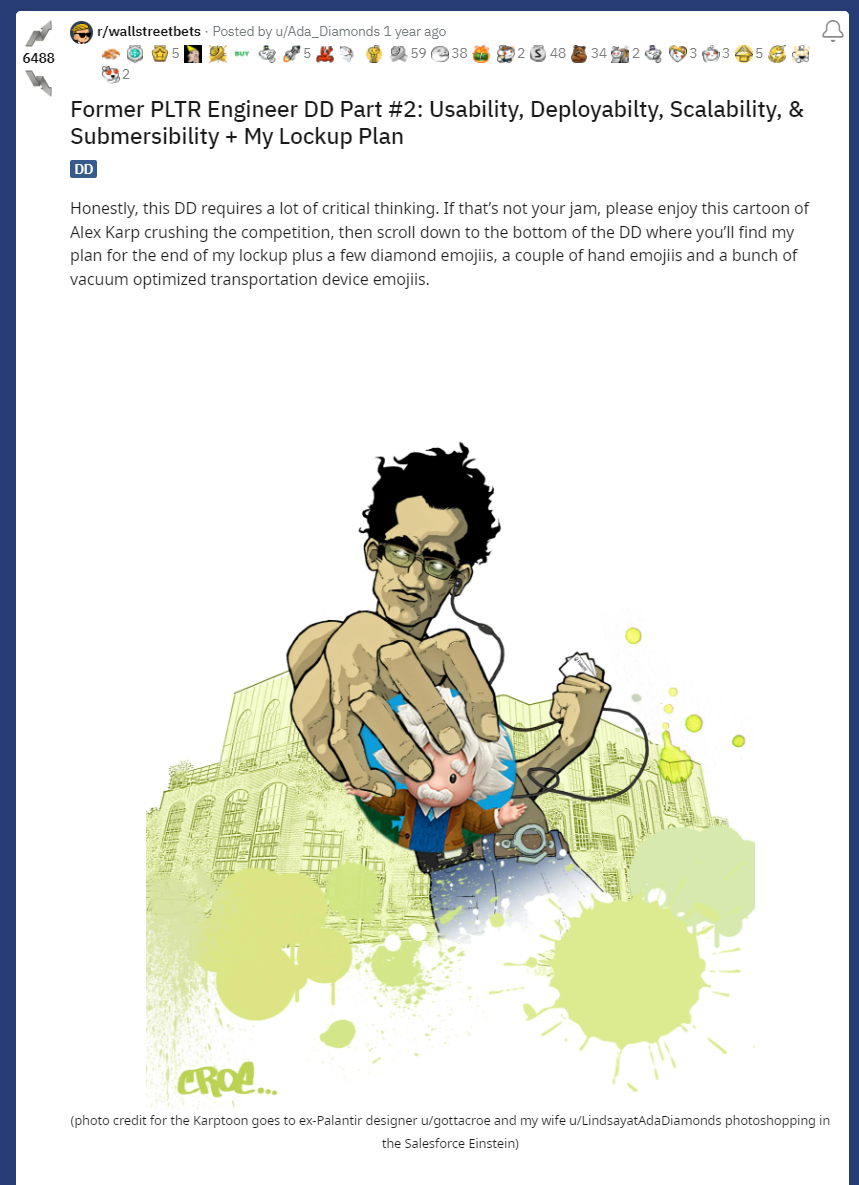

##Imports and aux functions

In [1]:
!pip install prophet
!pip install vaderSentiment


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 1.8 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 45 kB 1.9 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6641952 sha256=404ae185fda03b9cff80fa39e84ae0720e2b2afd62527cd1078deab89a429e4e
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
Looking in

In [77]:
from google.colab import drive
from prophet import Prophet
import gensim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import warnings
from gensim.models.doc2vec import Doc2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import string
from wordcloud import WordCloud
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def multy_ROC_curve_one_graph(y_test, y_score, labels ):
  n_class = 2 if len(y_train[y_train == "no change"]) == 0 else 3
  fpr = {}
  tpr = {}
  thresh ={}
  roc_auc = {}
  colors = ['orange', 'green', 'blue','red','purple','brown', 'pink','gray','olive','cyan']
  for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_score[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], linestyle='--',color=colors[i],
             label=( '{0}'.format(labels[i])))
  
  plt.plot([0, 1], [0, 1], color="navy", linestyle="-", label='random clf')
  plt.title('Multiclass ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.figure(figsize=(8, 6), dpi=80)
  plt.show()   

In [4]:
def get_metrices(y_test, prediction):
  cf_matrix = confusion_matrix(y_test, prediction)
  cl_report = classification_report(y_test, prediction)
  acc_score = accuracy_score(y_test, prediction) * 100
  return cf_matrix, cl_report, acc_score

In [5]:
def plot_confusion_matrix(cf_matrix, title):
  fig, ax = plt.subplots(figsize=(15,10))
  ax = sns.heatmap(cf_matrix, annot=True, linewidths=1, cmap='coolwarm', fmt='g', mask=cf_matrix<1)
  ax.set_facecolor('xkcd:black')
  ax.set(title=title)
  ax.plot()

In [6]:
def roc_curve_PC(clf, X_train, y_train):
  clf = OneVsRestClassifier(clf)
  clf = clf.fit(X_train, y_train)
  y_score =clf.predict_proba(X_test)
  labels=['negative', 'positive', 'no change']
  y_b = y_test.apply(lambda x : 0 if x == 'negative' else 1 if x == 'positive' else 2).values
  multy_ROC_curve_one_graph(y_b, y_score, labels)

In [7]:
def stock_date_show(stock_df, stock_name):
  date_to_show = []
  i = 0
  dates_range = len(stock_df)
  while i<=dates_range:
    date_to_show.append(stock_df['Date'].iloc[i])
    i += int(dates_range/4)
  date_to_show.append(stock_df['Date'].iloc[dates_range-1])
  x = stock_df['Date']
  plt.figure(figsize=(10,4))
  plt.plot(range(len(x)), stock_df['Open'])
  gap = int(dates_range/4)
  plt.xticks(ticks=[0,gap,gap*2,gap*3,gap*4], labels=date_to_show)
  plt.xlabel('Date', fontstyle = 'oblique', fontweight ='bold')
  plt.ylabel('Stock Value', fontstyle = 'oblique', fontweight ='bold')
  plt.title(f'{stock_name} Stock Values', color= 'blue', fontstyle = 'oblique')
  plt.show()

In [8]:
def normialized_sentiment_value_show(df, stock_df, stock_name):
  date_sentiment_df = pd.DataFrame(df.groupby('timestamp', as_index=False).agg({'sentiment': np.sum}))
  date_sentiment_df.rename(columns={'timestamp': 'Date'}, inplace=True)
  normialized_sentiment_value = date_sentiment_df.merge(pd.DataFrame([stock_df['Date'], stock_df['Open']]).T, on = 'Date')
  normialized_sentiment_value.sentiment = normialized_sentiment_value.sentiment.apply(lambda x:
                                                                                          x/normialized_sentiment_value.sentiment.max() if x >=0 
                                                                                          else -x/normialized_sentiment_value.sentiment.min())
  normialized_sentiment_value.Open = normialized_sentiment_value.Open.apply(lambda x: x/normialized_sentiment_value.Open.max())
  date_to_show = []
  dates_range = len(normialized_sentiment_value)
  i = 0
  while i<dates_range:
    date_to_show.append(normialized_sentiment_value['Date'].iloc[i])
    i += int(dates_range/4)
  date_to_show.append(normialized_sentiment_value['Date'].iloc[dates_range-1])
  x = normialized_sentiment_value['Date']
  plt.figure(figsize=(10,4))
  plt.plot(range(len(x)), normialized_sentiment_value['Open'], label='Opening price')
  plt.plot(range(len(x)), normialized_sentiment_value['sentiment'], label='Daily total sentiment')
  plt.legend(loc='lower right')
  gap = int(dates_range/4)
  plt.xticks(ticks=[0,gap,gap*2,gap*3,gap*4], labels=date_to_show)
  plt.xlabel('Date', fontstyle = 'oblique', fontweight ='bold')
  plt.ylabel('Normalized Value', fontstyle = 'oblique', fontweight ='bold')
  plt.title(f'{stock_name} Stock\n Sentiment VS value', color= 'blue', fontstyle = 'oblique')
  plt.show()

In [105]:
# function to calcualte sentiment of post
def sentiment_scores(sentence):
# Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
# polarity_scores method gives a sentiment dictionary, which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    if sentiment_dict['compound'] >= 0.05 :
        return 1
    elif sentiment_dict['compound'] <= - 0.05 :
        return -1
    else :
        return 0

In [10]:
def to_corpus(lines):
  for i, line in enumerate(lines):
    tokens = gensim.utils.simple_preprocess(line)
    yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [11]:
def doc2vec(df):
  # functions to add new columns to df- Doc2Vec_title and Doc2Vec_body.
  taggetDoc_title = list(to_corpus(df['title'].to_list()))
  modelD2V_title = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
  modelD2V_title.build_vocab(taggetDoc_title)
  modelD2V_title.train(taggetDoc_title, total_examples=modelD2V_title.corpus_count, epochs=modelD2V_title.epochs)
  df['Doc2Vec_title'] = df['title'].apply(lambda x: modelD2V_title.infer_vector(x))
  taggetDoc_body = list(to_corpus(df['body'].dropna().to_list()))
  modelD2V_body = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
  modelD2V_body.build_vocab(taggetDoc_body)
  modelD2V_body.train(taggetDoc_body, total_examples=modelD2V_body.corpus_count, epochs=modelD2V_body.epochs)
  df['Doc2Vec_body'] = df['body'].dropna().apply(lambda x: modelD2V_body.infer_vector(x) if x is not None else None )

In [12]:
import warnings
warnings.filterwarnings('ignore')

def create_wordclouds(data_frames):
  for df in data_frames:
    words_df = df[['title','body']]
    words_df['title'] = words_df['title'].str.lower()
    words_df['body'] = words_df['body'].str.lower()
    all_words = pd.concat([words_df['title'].str.split(' '), words_df['body'].str.split(' ')])

    all_words_cleaned = []
    for word in all_words:
      if isinstance(word, float):
        # if no title and no body, it's nan and not iterable
        continue
      text = [x.strip(string.punctuation) for x in word]
      all_words_cleaned.append(text)

    text = [" ".join(text) for text in all_words_cleaned]
    final_text = " ".join(text)

    wordcloud_spam = WordCloud(background_color="white", collocations=False).generate(final_text)
    plt.figure(figsize = (6,6))
    plt.imshow(wordcloud_spam, interpolation='bilinear')
    plt.axis("off")

  plt.show()

##Data Collection:

We leverage an existing corpus of r/wallstreetbets posts available on Kaggle
, consisting of all 44,293 posts from
September 2020 through March 2021

[the dataset from Kaggel](https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts)

In [13]:
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
posts_df = pd.read_csv('/content/drive/MyDrive/memeStocksData/reddit_wsb.csv')
posts_df.drop(columns=['created','id','url'], inplace=True)
posts_df["timestamp"] = posts_df["timestamp"].str[:10]
posts_day_count = pd.DataFrame(posts_df.groupby('timestamp')['title'].count())
posts_day_count.columns = ["posts_day_count"]
posts_df = posts_df.merge(posts_day_count, left_on="timestamp", right_on="timestamp")


we filtered the data set for posts over 3 specific meme stocks:
####NOK - blackberry, GMA - gamestop, AMC


In [15]:
# Creating posts DF for each stock
GME_posts_df = posts_df[posts_df['title'].str.contains('GME|$GME|gamestop|game stop',case=False) | posts_df['body'].str.contains('GME|$GME|gamestop|game stop',case=False) ]
AMC_posts_df = posts_df[posts_df['title'].str.contains('AMC',case=False) | posts_df['body'].str.contains('AMC',case=False) ]
NOK_posts_df = posts_df[posts_df['title'].str.contains('NOK|nokia',case=False) | posts_df['body'].str.contains('NOK|nokia',case=False)]
print("Columns of every Posts DF: ",list(GME_posts_df.columns))

Columns of every Posts DF:  ['title', 'score', 'comms_num', 'body', 'timestamp', 'posts_day_count']


In [16]:
GME_stocks_df = pd.read_csv('/content/drive/MyDrive/memeStocksData/GME.csv')
NOK_stocks_df = pd.read_csv('/content/drive/MyDrive/memeStocksData/NOK.csv')
AMC_stocks_df = pd.read_csv('/content/drive/MyDrive/memeStocksData/AMC.csv')

In [17]:
# Building the DataFrames (PC stands for price change)
GME_label_df=pd.concat([GME_stocks_df['Date'], pd.DataFrame(GME_stocks_df['Close'] - GME_stocks_df['Open'],columns = ['PC'])], axis = 1)
AMC_label_df=pd.concat([AMC_stocks_df['Date'], pd.DataFrame(AMC_stocks_df['Close'] - AMC_stocks_df['Open'],columns = ['PC'])], axis = 1)
NOK_label_df=pd.concat([NOK_stocks_df['Date'], pd.DataFrame(NOK_stocks_df['Close'] - NOK_stocks_df['Open'],columns = ['PC'])], axis = 1)
GME_df = GME_posts_df.merge(GME_label_df, left_on="timestamp", right_on="Date", how = 'left').drop('Date', 1)
AMC_df = AMC_posts_df.merge(AMC_label_df, left_on="timestamp", right_on="Date", how = 'left').drop('Date', 1)
NOK_df = NOK_posts_df.merge(NOK_label_df, left_on="timestamp", right_on="Date", how = 'left').drop('Date', 1)

####the data frames from Kaggle, filtered by stocks:


In [18]:
GME_df.sample(n=4)

,title,score,comms_num,body,timestamp,posts_day_count,PC
6020,GAMESTOP WONT STOP CANT STOP GREW E-COMMERCE R...,627,67,"I know you all are terrible at percents, and t...",2021-01-30,1424,NaN
9473,The spirit here is completely different today 🚀🚀🚀,314,37,https://giphy.com/gifs/rockymovie-movie-rocky-...,2021-02-05,2598,9.729999
9215,Washingtonpost on WSB retards,0,3,&#x200B;\n\n[https:\/\/www.washingtonpost.com\...,2021-02-05,2598,9.729999
10378,What is the value of this brand awareness camp...,14,6,"You couldn't buy this type of marketing, but i...",2021-02-06,2791,NaN


In [19]:
AMC_df.sample(n=4)

,title,score,comms_num,body,timestamp,posts_day_count,PC
4582,ONE PENNY? $AMC one cent???,252,104,NaN,2021-03-11,554,-0.37
831,THIS is the guy that got Robinhood to stop tra...,4,2,NaN,2021-01-29,15694,-1.05
480,"AMC, GME, BB - Robinhood not supporting",5,2,How is it remotely legal for RH to block buyer...,2021-01-29,15694,-1.05
2257,THAT G🌚🌚D DIP BEFORE TAKE OFF!!🚀🚀🚀AMC AMC AMC.,1,0,"Pos: GME, AMC and BB!!! This is not financial ...",2021-01-29,15694,-1.05


In [20]:
NOK_df.sample(n=4)

,title,score,comms_num,body,timestamp,posts_day_count,PC
1462,CiTaDeL bOtS pUsHiNg SiLvEr!,192,202,Since some of you are calling out SLV...\n\nA ...,2021-02-01,884,-0.08
1191,HOLDING NOK,1,7,HOLD HOLD HOLD HOLD\n\n&#x200B;\n\n\*Remember ...,2021-01-29,15694,-0.57
1646,Any idea what’s going on with NOK? I had 600 s...,9,9,NaN,2021-02-05,2598,-0.11
958,ALERT!!! Must Read!!! You can buy on Cash App,1,0,Right now you can buy shares of AMC and NOK on...,2021-01-29,15694,-0.57


###preprocessing the data:

we used some NLP technics that later be used to forecast price changes by the models


####VADER- text sentiment analysis
and 
####Doc2Vec - bag of words for a post

In [21]:
try:
  # save time of apply func if already calculated
  GME_df = pd.read_pickle('/content/drive/MyDrive/memeStocksData/GME_df_with_sentiment.pkl')
  AMC_df = pd.read_pickle('/content/drive/MyDrive/memeStocksData/AMC_df_with_sentiment.pkl')
  NOK_df = pd.read_pickle('/content/drive/MyDrive/memeStocksData/NOK_df_with_sentiment.pkl')
except:
  GME_df['sentiment'] = GME_df['title'].apply(sentiment_scores)
  AMC_df['sentiment'] = AMC_df['title'].apply(sentiment_scores)
  NOK_df['sentiment'] = NOK_df['title'].apply(sentiment_scores)
  doc2vec(GME_df)
  doc2vec(AMC_df)
  doc2vec(NOK_df)
  GME_df.to_pickle(path='/content/drive/MyDrive/memeStocksData/GME_df_with_sentiment.pkl')
  AMC_df.to_pickle(path='/content/drive/MyDrive/memeStocksData/AMC_df_with_sentiment.pkl')
  NOK_df.to_pickle(path='/content/drive/MyDrive/memeStocksData/NOK_df_with_sentiment.pkl')
GME_df.name = 'GME'
AMC_df.name = 'AMC'
NOK_df.name = 'NOK'

Columns 'Doc2Vec_title' and 'Doc2Vec_body' added to the DF:

In [22]:
GME_df.sample(n=3)

,title,score,comms_num,body,timestamp,posts_day_count,PC,sentiment,Doc2Vec_title,Doc2Vec_body
4838,THEORY: WE WERE F***ING RIGHT about $GME and S...,243,36,EDIT: TLDR; the SEC stopped global market's co...,2021-01-29,15694,-54.709991,1,"[-0.006403177, -0.009791367, -0.0073568183, -0...","[0.0050668335, -0.004772519, -0.006150543, -0...."
5523,Shifting crosshairs from GME to XRP. Let's mak...,0,18,"I've already netted over $1,000 on this this m...",2021-01-30,1424,NaN,-1,"[-0.0026447512, -0.0073839463, 0.009734175, -0...","[0.00921694, -0.0016894535, 0.004178083, -0.00..."
11050,📝🤲🏽 Mfing finessed my way out of all CC Debt (...,646,70,NaN,2021-02-08,287,-12.410004,-1,"[0.002925146, -0.005226502, -0.004814862, 0.00...",NaN


###Data frames per day

In our project, the question is whether we can predict the value of the stock tomorrow based on the stock history data (yesterday posts, for example). For that, we need to look at the data also from the perspective of days, so we create for each stock additional data frame aggregated by days.

In [52]:
# GME
day_GME_df = GME_df.groupby('timestamp', as_index=False).sum()
y = GME_df.groupby('timestamp', as_index=False)[['posts_day_count','PC']].count().drop(columns='timestamp')
day_GME_df[['posts_day_count','PC']] = day_GME_df[['posts_day_count','PC']].div(y)
day_GME_df.name = GME_df.name

# AMC
day_AMC_df = AMC_df.groupby('timestamp', as_index=False).sum()
y = GME_df.groupby('timestamp', as_index=False)[['posts_day_count','PC']].count().drop(columns='timestamp')
day_AMC_df[['posts_day_count','PC']] = day_AMC_df[['posts_day_count','PC']].div(y)
day_AMC_df.name = AMC_df.name

# NOK
day_NOK_df = NOK_df.groupby('timestamp', as_index=False).sum()
y = GME_df.groupby('timestamp', as_index=False)[['posts_day_count','PC']].count().drop(columns='timestamp')
day_NOK_df[['posts_day_count','PC']] = day_NOK_df[['posts_day_count','PC']].div(y)
day_NOK_df.name = NOK_df.name

# for GME we create also a "day before" df
day_before = day_GME_df
day_before['PC']  = day_before['PC'].shift(-1)
day_before.sample(n=3)

,timestamp,score,comms_num,posts_day_count,PC,sentiment
97,2021-05-08,18819,2392,126.0,NaN,6
68,2021-04-06,40072,20901,78.0,-5.250000,3
98,2021-05-09,16081,453,41.0,-18.089997,0


##Exploratory Data Analysis

Here are few visual approaches to present our data.
At the end of each of them, we wrote our conclusions, observasions and reaserch questions that came up from it.

###Stocks value over time:

In [24]:
m = Prophet()
m.fit(GME_stocks_df[['Date','Close']].rename(columns= {'Date': 'ds', 'Close': 'y'}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [25]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
499,2022-08-12
500,2022-08-13
501,2022-08-14
502,2022-08-15
503,2022-08-16


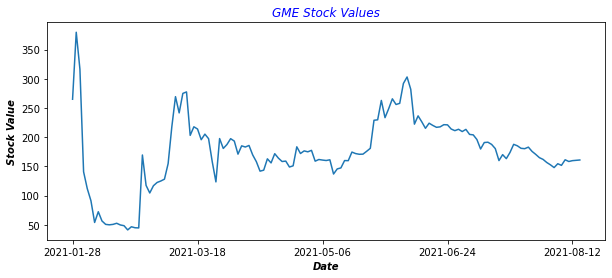

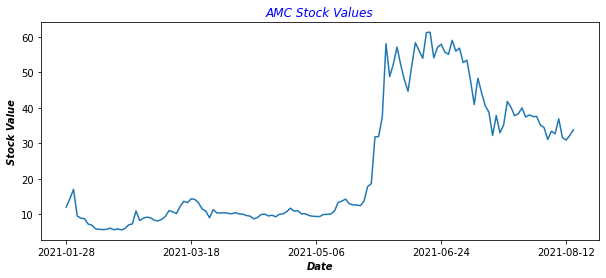

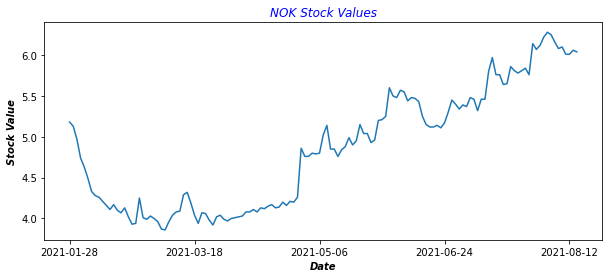

In [26]:
stock_date_show(GME_stocks_df, "GME")
stock_date_show(AMC_stocks_df, "AMC")
stock_date_show(NOK_stocks_df, "NOK")

First observation is that all 3 stocks had at list one segnificant event (dramatic price change) in our dates range.
It is important for our model, in order to be able to learn what social circumstances can cause or relate to such change.

The big story of GME short squeeze happend in January 2021, and our dataset starts at the end of the rapid increase. That is the reason for the big drop at the beginning of GME.
We are wondering rather to expand the dataset, so it contain the whole increase process of GME or to cut it so the it will start straight after it- We think that starting in the middle of the short squeeze might constitute a difficulty for our model to learn.

###Price changes distribution

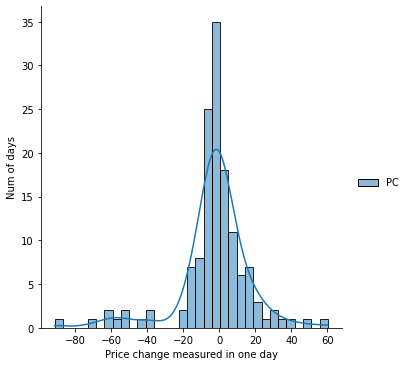

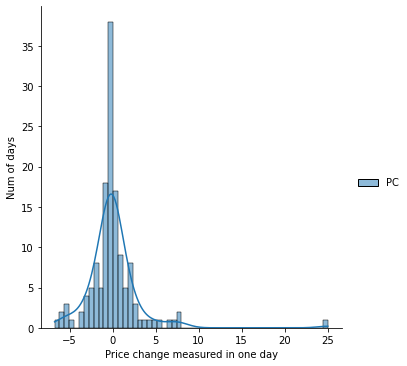

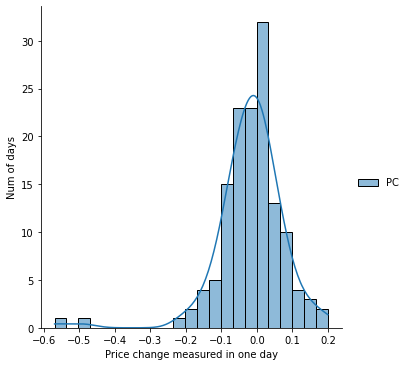

In [27]:
sns.displot(GME_label_df, kde=True).set_axis_labels("Price change measured in one day", "Num of days")
sns.displot(AMC_label_df, kde=True).set_axis_labels("Price change measured in one day", "Num of days")
sns.displot(NOK_label_df, kde=True).set_axis_labels("Price change measured in one day", "Num of days")

We can see that in our 3 chosen stocks, the major changes have been in the GME stock values- it has changes of over 40\$ in one day (and up to -90\$), while the largest change in AMC was 25\$, and for NOK -0.55\$.
We can learn that GME stock "acts" radically, and we should be espesially carful and cautious while analyzing it.

###Analyzing pairwise relationships between features

In [150]:
union_df = pd.concat([day_GME_df.assign(stock_name="GME"), day_AMC_df.assign(stock_name="AMC"), day_NOK_df.assign(stock_name="NOK")])
fig = px.scatter_matrix(union_df, dimensions=["score", "comms_num", "posts_day_count", "sentiment"], color='stock_name')
fig.show()

In [154]:
union_df.sort_values('comms_num')

,timestamp,score,comms_num,posts_day_count,PC,sentiment,stock_name
80,2021-05-28,33,1,42.750000,-inf,1,NOK
55,2021-04-10,0,7,2.050000,0.000000,1,NOK
157,2021-08-03,10,7,27.500000,-inf,0,AMC
88,2021-06-18,14,7,28.666667,-0.003333,1,NOK
165,2021-08-07,23,8,36.000000,NaN,0,GME
...,...,...,...,...,...,...,...
28,2021-02-25,366253,181849,545.000000,-15.720001,4,GME
4,2021-02-01,1345002,183279,884.000000,-50.759995,38,GME
6,2021-02-03,827242,198641,2643.000000,-37.690002,88,GME
1,2021-01-29,1585323,307160,15694.000000,NaN,-115,GME


###Normalized Sentiment VS Value

we see a partly correlation between the normalized sentiment and price changes

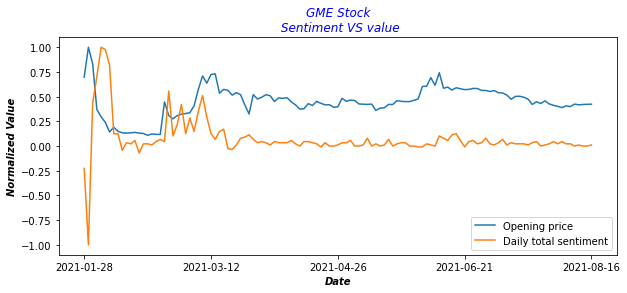

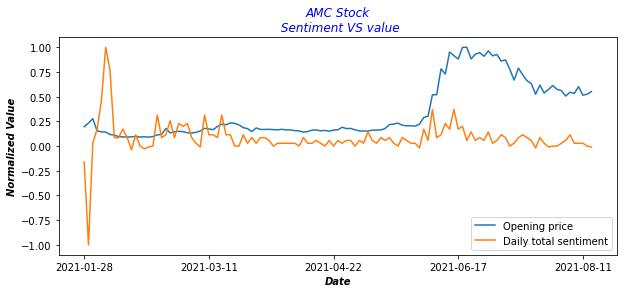

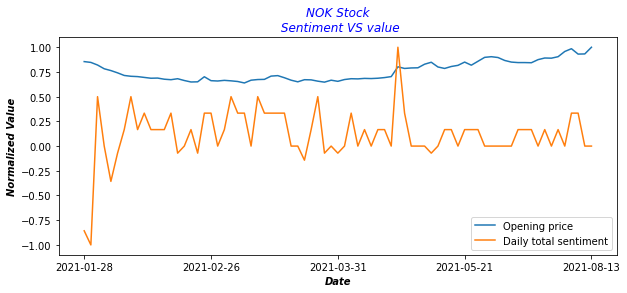

In [28]:
normialized_sentiment_value_show(GME_df, GME_stocks_df, "GME")
normialized_sentiment_value_show(AMC_df, AMC_stocks_df, "AMC")
normialized_sentiment_value_show(NOK_df, NOK_stocks_df, "NOK")

We can see that significant price increasments in GME and AMC (blue curve) are usually accompanied by a strong positive sentiment, and the big drop in GME at the beginning of February 2021 was accompanied by a strong negative sentiment.

In contrast- NOK stock value seems to be more insensitive to sentiments, even though the sentiment differents are less radical. The strongest sentiment for NOK does accompanied by a small value increasment.

###Amount of posts per stock

First we'll plot a violin graph of each stock for the whole period:

In [71]:
#@title Violin Graph
fig = go.Figure()

for stock_df in [day_GME_df, day_AMC_df, day_NOK_df]:
  fig.add_trace(go.Violin(y=stock_df['posts_day_count'],
                          name=stock_df.name,
                          box_visible=True,
                          meanline_visible=True))

fig.show()

In [76]:
#@title Violin Graph from day 10
fig = go.Figure()

for stock_df in [day_GME_df, day_AMC_df, day_NOK_df]:
  fig.add_trace(go.Violin(y=stock_df['posts_day_count'][100:],
                          name=stock_df.name,
                          box_visible=True,
                          meanline_visible=True))

fig.show()

We can see that out data starts with a very radical situation, where the nuber of comments is very high, and after 10 days the distribution is getting normal again.

###Semantic Distribution

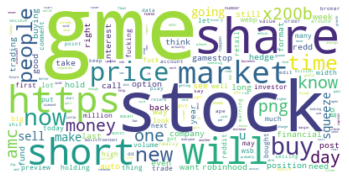

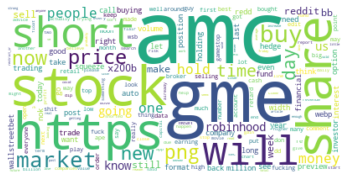

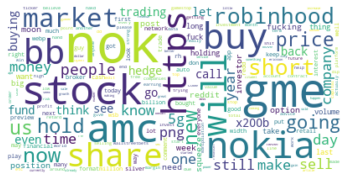

In [ ]:
create_wordclouds([GME_df, AMC_df, NOK_df])

Looking at the most common words, we can see that most of them are neutral, and some are even not related to the post saying (like 'http' and 'png').

We cannot say rather we should consider the sentiment feature as a main feature for predicting value change or not, but it worth to test the effect of the post's nerative on our results mainly when it's a strong one- means that in one day, many posts had a clear strong sentiment.

In [ ]:
# FreqDist(word.lower() for word in word_tokenize(final_text)).plot(20, cumulative=True)

##Brute Force Algorithms

### Analitical Regressions

First, we used linear and logistic regression to analyze the connection between the features and the stock's price change. 

#### Linear Regression

#####First Model

We started with a simple linear regression model:

$PC_{day_{i+1}}= α_0*score_{day_i}+α_1*comms_{day_i}+α_2*posts_{day_i}+α_3*sentiment_{day_i}$


while:

* $score_{day_i}$ : sum of scores of all posts in day i over GME in r/wallstreetbets channel. the score of a post is determined by the number of upvotes (likes) minus the number of downvots (dislikes) upon the post .

* $comms_{day_i}$ : sum of all the comments over all the posts in day i over GME in r/wallstreetbets channel

* $posts_{day_i}$ : number of posts posted in day i over GME in r/wallstreetbets channel

* $sentiment_{day_i}$ : sum of all sentiments score determined by VADER of posts posted in day i over GME in r/wallstreetbets 

* $PC_{day_{i+1}}$ : Price changes (open - close) in the GME stock's value on day i+1 (predicted variable)




In [ ]:
linear_df = day_before.dropna().copy(deep=True)
linear_df.drop(['timestamp'], axis=1, inplace=True)
model = sm.OLS(linear_df['PC'],linear_df.drop(['PC'], axis=1))
results = model.fit()
results.params
r = np.ones_like(results.params)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     PC   R-squared (uncentered):                   0.264
Model:                            OLS   Adj. R-squared (uncentered):              0.238
Method:                 Least Squares   F-statistic:                              10.39
Date:                Fri, 20 May 2022   Prob (F-statistic):                    3.17e-07
Time:                        09:30:44   Log-Likelihood:                         -510.61
No. Observations:                 120   AIC:                                      1029.
Df Residuals:                     116   BIC:                                      1040.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
score           -5.872e-05   1.28e-05     -4.588      0.000   -8.41e-05   -3.34e-05
comms_num           0.0002   6.52e-05      2.608      0.010    4.09e-05       0.000
posts_day_count    -0.0204      0.008     -2.442      0.016      -0.037      -0.004
sentiment           0.5050      0.185      2.725      0.007       0.138       0.872
==============================================================================
Omnibus:                       17.325   Durbin-Watson:                   2.303
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.089
Skew:                          -0.119   Prob(JB):                     4.95e-17
Kurtosis:                       6.868   Cond. No.                     3.21e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can see high levels of significance in both t values and F values. Therefore, the features have a high probability of being relevant for the predictions. But, the $R^2$ score is 0.264 which is low. So, the simple model isn't complex enough to predict the PC with efficient accuracy. To improve accuracy, we will try a more complex model with more features.


#####second model

$PC_{day_{i+1}}=α_0*score_{day_i}+α_1*comms_{day_i}+α_2*posts_{day_i}+α_3*sentiment_{day_i}+α_4*score_{day_i}*sentiment_{day_i}+α_5*comms_{day_i}*sentiment_{day_i}+α_6*posts_{day_i}*sentiment_{day_i}+α_7*posts_{day_i}^2+α_8*sentiment_{day_i}^2+α_9*score_{day_i}^2+α_{10}*comms_{day_i}^2$

We added interactions between every two initial features and polyinomial features to each feature in order to allow the model to integrate interactions between features and polynomial effects. 

In [ ]:
linear_df['sentiment*score'] = linear_df['sentiment']*linear_df['score']
linear_df['sentiment*comms_num'] = linear_df['sentiment']*linear_df['comms_num']
linear_df['posts_day_count*sentiment'] = linear_df['posts_day_count']*linear_df['sentiment']
linear_df['posts_day_count**2'] = linear_df['posts_day_count']**2
linear_df['sentiment**2'] = linear_df['sentiment']**2
linear_df['score**2'] = linear_df['score']**2
linear_df['comms_num**2'] = linear_df['comms_num']**2

model = sm.OLS(linear_df['PC'],linear_df.drop(['PC'], axis=1))
results = model.fit()
results.params
r = np.ones_like(results.params)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     PC   R-squared (uncentered):                   0.357
Model:                            OLS   Adj. R-squared (uncentered):              0.292
Method:                 Least Squares   F-statistic:                              5.502
Date:                Fri, 20 May 2022   Prob (F-statistic):                    6.17e-07
Time:                        09:30:44   Log-Likelihood:                         -502.48
No. Observations:                 120   AIC:                                      1027.
Df Residuals:                     109   BIC:                                      1058.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
score                       2.89e-05    3.3e-05      0.876      0.383   -3.65e-05    9.43e-05
comms_num                  3.779e-05      0.000      0.268      0.789      -0.000       0.000
posts_day_count               0.0020      0.023      0.087      0.930      -0.043       0.047
sentiment                    -1.0229      0.575     -1.780      0.078      -2.162       0.116
sentiment*score            -1.68e-06   3.03e-06     -0.554      0.581   -7.69e-06    4.33e-06
sentiment*comms_num        8.063e-06   5.81e-06      1.387      0.168   -3.46e-06    1.96e-05
posts_day_count*sentiment     0.0012      0.001      1.700      0.092      -0.000       0.003
posts_day_count**2        -5.126e-05   2.32e-05     -2.210      0.029   -9.72e-05   -5.29e-06
sentiment**2                  0.0141      0.014      1.033      0.304      -0.013       0.041
score**2                  -2.032e-11   6.66e-11     -0.305      0.761   -1.52e-10    1.12e-10
comms_num**2              -2.547e-10   8.79e-10     -0.290      0.772      -2e-09    1.49e-09
==============================================================================
Omnibus:                       27.475   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.595
Skew:                          -0.595   Prob(JB):                     5.34e-28
Kurtosis:                       7.869   Cond. No.                     1.20e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In terms of statistical significance, the F value is still significant within a confidence interval of 95%. So, the model is relevant for predicting PC value. But, the T value of every feature except the $posts^2$ is not high enough. So in terms of analysing the features, we can only assume that the influence of the number of posts in a day isn't linear. And, can't know the exact relevance of the other features in the model.
We can also see an improvement in the accuracy score ($R^2$) to 0.357 as we wanted to achieve.

####Logistic Regression

After getting maximum accuracy of 0.357 with the linear regression we turn to a logistic regression model. With it we can only classify to classes - negative, positive or natural PC value. So we are taking the second, more complax model, from before and change the predicted values into classes.

In [ ]:
logistic_df = linear_df.copy(deep=True)
logistic_df['PC']= logistic_df['PC'].apply(lambda x: 'positive' if x>0 else 'negative' if x<0 else 'no change' if x==0 else None)
logistic_df.dropna(inplace=True)
x = logistic_df.drop(['PC'], axis=1)
y = logistic_df['PC']
clf = LogisticRegression(random_state=0).fit(x, y)
clf.score(x, y)

0.5666666666666667

We have a significant improvement in the accuracy score from the linear model (0.56 VS 0.357). Thus, simply classifying the trend in a stock's value is likely easier than trying to predict the exact price movements. 

###Classifiers

After using analitical regressions over the data we turn to use a classical simple classfiing algorithms:
* Random Forest (RF)
* k nearest neighbors (KNN)
* Support vector machine (SVM)

In order to let the algorithms extract features from the clean data frame, we return to the clean data frame with it classifying to classes version.

In [ ]:
cls_df = day_before.dropna().copy(deep=True)
cls_df['PC']= cls_df['PC'].apply(lambda x: 'positive' if x>0 else 'negative' if x<0 else 'no change' if x==0 else None)
cls_df.drop(['timestamp'], axis=1, inplace=True)
cls_df.dropna(inplace=True)
x = cls_df.drop(['PC'], axis=1)
y = cls_df['PC']
cls_df.sample(n=4)

,score,comms_num,posts_day_count,PC,sentiment
169,108,179,91.0,positive,1
11,237034,54150,287.0,negative,11
14,160116,37836,169.0,positive,3
54,63686,41586,113.0,negative,7


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

####Random Forest

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.5

####SVM

In [ ]:
from sklearn import svm

clf = svm.SVC(kernel="rbf", C=1, probability=True)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.625

####KNN

In [ ]:
knn = KNeighborsClassifier(5)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.75

We are getting the highest score with KNN (o.75 VS 0.625 and 0.542).

####KNN  roc and report:

To learn more about the problem, we are analyzing the most accurate classifier results (KNN):



In [ ]:
y_pred = knn.predict(X_test)
knn_cf_matrix, knn_cl_report, knn_acc_score = get_metrices(y_test,y_pred)
print(knn_cl_report)

              precision    recall  f1-score   support

    negative       0.85      0.73      0.79        15
    positive       0.64      0.78      0.70         9

    accuracy                           0.75        24
   macro avg       0.74      0.76      0.74        24
weighted avg       0.77      0.75      0.75        24



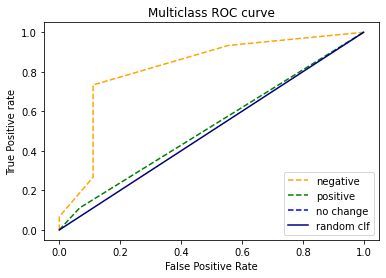

<Figure size 640x480 with 0 Axes>

In [ ]:
roc_curve_PC(knn, X_train, y_train)

We can see that the algorithm can predict with more precision negative trends in the stock price than positive ones. 
This can suggest a stronger relationship between a decrease in stock value and the reddit posts than an increase in stock value. But, it could also be connected to the fact that our database is limited to a specific period and specifically lacks the initiation of the GME frenzy.ueese.

##Conclusion

In this Project Suggestion, we discussed the connections between trends on the social media platform - Reddit and specific stocks values. 
We used a premade Kaggle dataset and processed it to our needs by hard-coded actions and premade libraries such as VADER. 
We defined the question we intend to investigate - **whether we can predict the value of the stock tomorrow based on today's data** 

We applied some classical algorithms to the data in order to show that the connection may be causal or at least correlative.

As a result, we plan to continue to study it in our project. 
This will enable us to have a better grasp of the connections in our question field and to get better accurate results

###Looking forward to the project:
we intend to do the following:

*   using the data from all the 3 stocks for the classification
*   trying deep neural network over the VADER sentiment and the Doc2Vec vectors
*   augmenting the dataset by Reddit API - specifically to the period before the GME's short squeeze. As we mentioned, our data from kaggle starts in the middle of the big hype of the Meme-Stocks, and for that reason it is many times distorted for predictions. In some cases it is better to skip the first days of sampling to get a more stable prediction.
*   extracting more features from the links, photos, and videos from the posts
*   adding more stocks than GME, AMC, and NOK

